# MNIST/Fashion MNIST GAN Implementation

This notebook implements a Generative Adversarial Network (GAN) trained on either the MNIST digits or Fashion MNIST dataset using PyTorch. This serves as the foundation for investigating whether informative data samples exist for GAN training, similar to those found in supervised learning.

## Thesis Context
Recent research has shown that state-of-the-art machine learning models can be trained effectively using only specific subsets of training data. These "informative samples" enhance generalization in neural networks. While this phenomenon has been observed in supervised learning, this project aims to investigate whether similar informative samples exist when training generative models like GANs.

## Notebook Overview
1. **Setup and Imports**: Libraries and device configuration
2. **Hyperparameters**: Configuration for the GAN training
3. **Model Architecture**: Implementation of Generator and Discriminator networks
4. **Data Loading**: Dataset preparation with choice between MNIST digits or Fashion MNIST
5. **Visualization Functions**: Utilities for tracking GAN performance
6. **Training Loop**: Implementation of the GAN training process
7. **Execution and Results**: Running the training and analyzing outputs

## 1. Setup and Imports

First, we'll import the necessary libraries and set up the computational device (CPU or GPU).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os
import time
import random

# Set random seed for reproducibility
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Hyperparameters

Here we define all the hyperparameters that control the GAN training process. These include:

- Batch size: Number of images processed in each training step
- Latent dimension: Size of the random noise vector input to the generator
- Hidden dimensions: Size of hidden layers in the networks
- Learning rates and optimizer parameters
- Training duration and image sampling frequency

In [2]:
# Hyperparameters
batch_size = 128
latent_dim = 128     # Size of generator input noise vector
hidden_dim = 256     # Size of hidden layers
image_size = 28 * 28 # MNIST image dimensions flattened
lr = 0.0002     
beta1 = 0.5          
beta2 = 0.999  
num_epochs = 100
sample_interval = 10 # Save images every 10 epochs

## 3. Model Architecture

### Generator Network

The Generator transforms random noise vectors into synthetic images. Its architecture consists of:
- Input: Random noise vector (latent_dim)
- Multiple fully connected layers with LeakyReLU activations
- Output: Image with values in range [-1, 1] through Tanh activation

This implementation uses a simple MLP (Multi-Layer Perceptron) architecture rather than convolutional layers for simplicity.

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to image dimensions
        return img

### Discriminator Network

The Discriminator evaluates whether an image is real (from the dataset) or fake (generated). Its architecture consists of:
- Input: Flattened image (28×28 = 784 dimensions)
- Multiple fully connected layers with LeakyReLU activations and dropout for regularization
- Output: Single value between 0-1 through Sigmoid activation (probability of image being real)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output between 0-1 (probability of being real)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)
        return validity

### Initialize Models and Optimizers

Here we:
1. Initialize both networks
2. Define the loss function (Binary Cross Entropy)
3. Set up optimizers for both networks

In [ ]:
# Initialize models
generator = Generator(latent_dim, hidden_dim, image_size).to(device)
discriminator = Discriminator(image_size, hidden_dim).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

## 4. Data Loading

Here we set up either the MNIST digits or Fashion MNIST dataset with appropriate transformations:
- ToTensor: Converts PIL images to PyTorch tensors
- Normalize: Scales pixel values from [0,1] to [-1,1] to match the Generator's Tanh output

We've extended the function to support both dataset types.

In [8]:
def load_data(subset_percentage=100, dataset_type='digits'):
    """
    Load either MNIST digits or Fashion MNIST dataset
    
    Parameters:
    - subset_percentage: Percentage of the full dataset to use (integer from 1-100)
    - dataset_type: Either 'digits' for original MNIST or 'fashion' for Fashion MNIST
    
    Returns:
    - DataLoader and Dataset objects
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    
    if dataset_type.lower() == 'digits':
        full_dataset = torchvision.datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
        class_names = [str(i) for i in range(10)]  # 0-9 digits
    elif dataset_type.lower() == 'fashion':
        full_dataset = torchvision.datasets.FashionMNIST(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    else:
        raise ValueError("dataset_type must be either 'digits' or 'fashion'")
    
    all_targets = full_dataset.targets.numpy()
    
    # Count instances of each class
    class_counts = [0] * 10
    for label in all_targets:
        class_counts[label] += 1
    
    print(f"Full {dataset_type} dataset distribution:")
    for class_idx, count in enumerate(class_counts):
        class_label = class_names[class_idx] if dataset_type.lower() == 'fashion' else f"Digit {class_idx}"
        print(f"{class_label}: {count} samples")
    
    if subset_percentage == 100:
        selected_dataset = full_dataset
    else:
        class_indices = [[] for _ in range(10)]
        
        for idx, label in enumerate(all_targets):
            class_indices[label].append(idx)
        
        total_subset_size = int(len(full_dataset) * subset_percentage / 100)
        samples_per_class = total_subset_size // 10
        
        stratified_indices = []
        for class_idx in range(10):
            class_idx_list = class_indices[class_idx]
            random_idx = torch.randperm(len(class_idx_list))

            selected_idx = [class_idx_list[i] for i in random_idx[:samples_per_class]]
            stratified_indices.extend(selected_idx)
            
        random.shuffle(stratified_indices)
        selected_dataset = torch.utils.data.Subset(full_dataset, stratified_indices)
        
        subset_class_counts = [0] * 10
        for idx in stratified_indices:
            label = all_targets[idx]
            subset_class_counts[label] += 1
        
        print(f"\nStratified subset distribution ({dataset_type}):")
        for class_idx, count in enumerate(subset_class_counts):
            class_label = class_names[class_idx] if dataset_type.lower() == 'fashion' else f"Digit {class_idx}"
            print(f"{class_label}: {count} samples")
    
    data_loader = DataLoader(
        selected_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True  # Discard incomplete batches
    )
    
    print(f"\nFull dataset size: {len(full_dataset)} images")
    print(f"Selected subset size: {len(selected_dataset)} images")
    print(f"Number of batches: {len(data_loader)}")
    
    return data_loader, selected_dataset

In [9]:
# load data form informative subsets folder 
def load_informative_subsets(subset_percentage=100):
    data_path = 'data/easiest_class_subsets'
    
    # load data from pt file depending on the percentage. 
    file_name = f"mnist_train_easiest_{subset_percentage}p.pt"
    file_path = os.path.join(data_path, file_name)
    
    dataset = torch.load(file_path)
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    
    print(f"\nLoaded dataset from {file_path}")
    print(f"Selected subset size: {len(data_loader.dataset)} images")
    print(f"Number of batches: {len(data_loader)}")
    
    return data_loader, dataset

## 5. Visualization Functions

These utility functions help monitor the GAN's progress:

1. `save_generated_images`: Creates and saves a grid of generated images
2. `plot_losses`: Visualizes generator and discriminator losses over time

Both functions have been updated to include the dataset type.

In [10]:
def save_generated_images(epoch, generator, latent_dim, device, subset_percentage,
                        dataset_type, fixed_noise=None, base_path="../generated_images"):
    
    subfolder = f"{dataset_type}_subset_{subset_percentage}_percent"
    save_path = os.path.join(base_path, subfolder)
    os.makedirs(save_path, exist_ok=True)
    
    # Create a batch of latent vectors or use fixed noise for comparison
    if fixed_noise is None:
        z = torch.randn(25, latent_dim).to(device)
    else:
        z = fixed_noise
    
    # Generate images
    with torch.no_grad():
        gen_imgs = generator(z).detach().cpu()
    
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    grid = make_grid(gen_imgs, nrow=5, normalize=True)
    
    filename = f"epoch_{epoch:03d}.png"
    filepath = os.path.join(save_path, filename)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(f"Generated {dataset_type.capitalize()} Images - {subset_percentage}% Data - Epoch {epoch}")

    plt.savefig(filepath)
    plt.show()
    
    return grid

In [11]:
def plot_losses(g_losses, d_losses, subset_percentage, dataset_type, save_path="../loss_plots"):
    # Create folder structure
    os.makedirs(save_path, exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title(f'{dataset_type.capitalize()} GAN Training Losses - {subset_percentage}% Data')
    
    plt.savefig(f"{save_path}/{dataset_type}_losses_subset_{subset_percentage}_percent.png")
    plt.show()

## 6. Training Loop

The GAN training function implements the adversarial training process with these key steps:

1. **Initialization**:
   - Create fixed noise vector for consistent image generation across epochs
   - Initialize lists to track losses

2. **For each epoch and batch**:
   - **Train Discriminator**:
     - Forward pass with real images → calculate loss on real images
     - Generate fake images → calculate loss on fake images
     - Update discriminator weights
   - **Train Generator**:
     - Generate fake images
     - Calculate loss based on discriminator's prediction
     - Update generator weights

3. **Monitoring**:
   - Save losses for plotting
   - Generate and save images at regular intervals
   - Track and display progress information

The function has been updated to support the dataset type parameter.

In [12]:
def train_gan(subset_percentage=100, dataset_type='digits'):
    # Generate fixed noise for consistent image generation
    fixed_noise = torch.randn(25, latent_dim).to(device)
    
    # Load the selected dataset
    global train_loader, train_dataset
    train_loader, train_dataset = load_data(subset_percentage, dataset_type)
    #train_loader, train_dataset = load_informative_subsets(subset_percentage)
    
    # lists to store losses
    g_losses = []
    d_losses = []
    start_time = time.time()
    
    print(f"Starting Training on {dataset_type.capitalize()} Dataset...")
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        batch_count = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_count += 1
            
            # Configure input
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Create labels with a small amount of label smoothing
            valid = torch.ones(batch_size, 1).to(device) * 0.9
            fake = torch.zeros(batch_size, 1).to(device)
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # Loss on real images
            real_pred = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, valid)
            
            # Sample noise and generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Loss on fake images
            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)
            
            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()
            
            # Generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Try to fool the discriminator
            validity = discriminator(fake_imgs)
            g_loss = adversarial_loss(validity, valid)
            
            g_loss.backward()
            optimizer_G.step()
            
            # Save losses for plotting
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                      f"[Time: {time.time() - start_time:.2f}s]")
        
        # Calculate and store average losses for this epoch
        g_losses.append(g_loss_epoch / batch_count)
        d_losses.append(d_loss_epoch / batch_count)
        
        # Print epoch summary
        print(f"[Epoch {epoch}/{num_epochs}] "
              f"[Avg D loss: {d_losses[-1]:.4f}] [Avg G loss: {g_losses[-1]:.4f}]")

        
        # Save generated images at specified intervals
        if epoch % sample_interval == 0 or epoch == num_epochs - 1:
            _ = save_generated_images(epoch, generator, latent_dim, device, 
                                     subset_percentage, dataset_type, fixed_noise)
            
        # Plot losses at each epoch
        if epoch % 10 == 0:
            plot_losses(g_losses, d_losses, subset_percentage, dataset_type)
    
    plot_losses(g_losses, d_losses, subset_percentage, dataset_type)
    
    print("Training finished!")
    print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")
    
    # Update the model saving to include dataset type and subset percentage
    model_path = f"../models/{dataset_type}_subset_{subset_percentage}_percent"
    os.makedirs(model_path, exist_ok=True)
    torch.save(generator.state_dict(), f'{model_path}/generator.pth')
    torch.save(discriminator.state_dict(), f'{model_path}/discriminator.pth')
    
    print("Models saved!")
    
    return g_losses, d_losses

## 7. Execution and Results

Now we'll run the training function and analyze the results. We've added a function to generate and display samples after training.

In [13]:
def generate_samples(dataset_type):
    """Generate and display random samples from the trained generator"""
    with torch.no_grad():
        # Generate random noise
        z = torch.randn(16, latent_dim).to(device)
        # Generate images
        samples = generator(z).detach().cpu()
        # Rescale images
        samples = 0.5 * samples + 0.5
        # Display images
        grid = make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f"Random {dataset_type.capitalize()} Samples from Trained Generator")
        plt.show()

Full digits dataset distribution:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples

Full dataset size: 60000 images
Selected subset size: 60000 images
Number of batches: 468
Starting Training on Digits Dataset...
[Epoch 0/100] [Batch 0/468] [D loss: 1.5035] [G loss: 0.9231] [Time: 0.50s]
[Epoch 0/100] [Batch 100/468] [D loss: 1.2128] [G loss: 2.0861] [Time: 5.60s]
[Epoch 0/100] [Batch 200/468] [D loss: 1.1872] [G loss: 1.0130] [Time: 10.59s]
[Epoch 0/100] [Batch 300/468] [D loss: 1.2267] [G loss: 0.7892] [Time: 15.51s]
[Epoch 0/100] [Batch 400/468] [D loss: 1.0772] [G loss: 1.1549] [Time: 20.27s]
[Epoch 0/100] [Avg D loss: 1.0813] [Avg G loss: 1.4522]


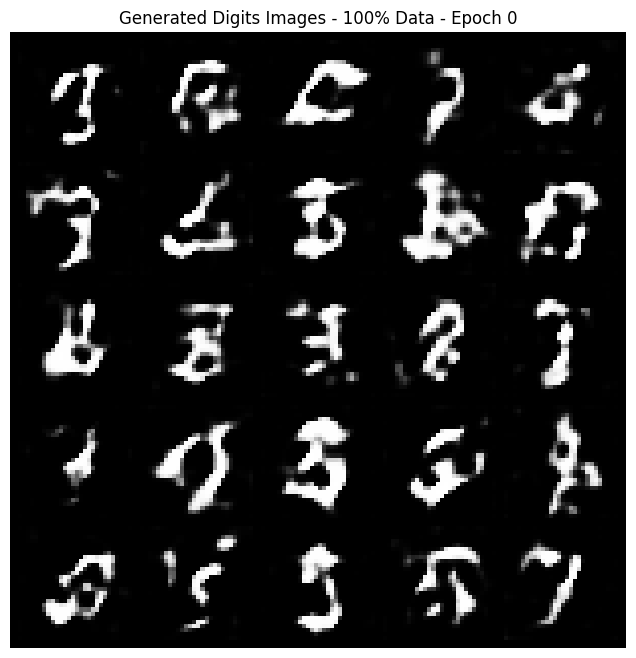

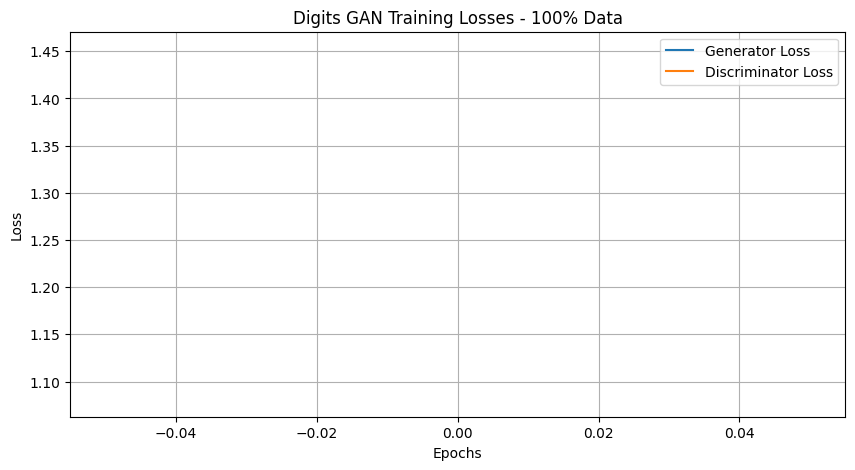

[Epoch 1/100] [Batch 0/468] [D loss: 1.1999] [G loss: 1.5604] [Time: 23.92s]
[Epoch 1/100] [Batch 100/468] [D loss: 1.0903] [G loss: 1.3903] [Time: 28.92s]
[Epoch 1/100] [Batch 200/468] [D loss: 1.0205] [G loss: 1.2830] [Time: 33.90s]
[Epoch 1/100] [Batch 300/468] [D loss: 1.0534] [G loss: 1.2838] [Time: 38.85s]
[Epoch 1/100] [Batch 400/468] [D loss: 1.2409] [G loss: 1.2302] [Time: 43.64s]
[Epoch 1/100] [Avg D loss: 1.1058] [Avg G loss: 1.2777]
[Epoch 2/100] [Batch 0/468] [D loss: 1.1988] [G loss: 1.2784] [Time: 46.92s]
[Epoch 2/100] [Batch 100/468] [D loss: 1.2698] [G loss: 0.8688] [Time: 51.76s]
[Epoch 2/100] [Batch 200/468] [D loss: 1.2007] [G loss: 1.0008] [Time: 56.56s]
[Epoch 2/100] [Batch 300/468] [D loss: 1.1648] [G loss: 1.4530] [Time: 61.34s]
[Epoch 2/100] [Batch 400/468] [D loss: 1.1775] [G loss: 1.0970] [Time: 66.17s]
[Epoch 2/100] [Avg D loss: 1.1746] [Avg G loss: 1.1613]
[Epoch 3/100] [Batch 0/468] [D loss: 1.1317] [G loss: 1.1174] [Time: 69.49s]
[Epoch 3/100] [Batch 100/

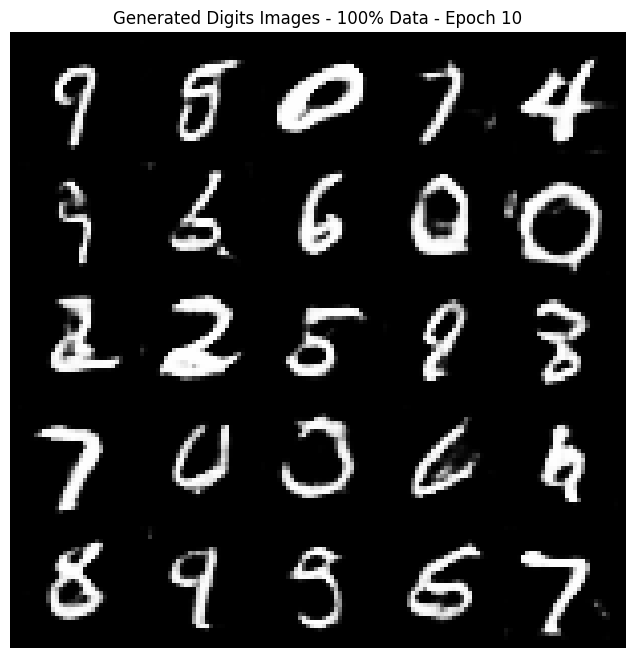

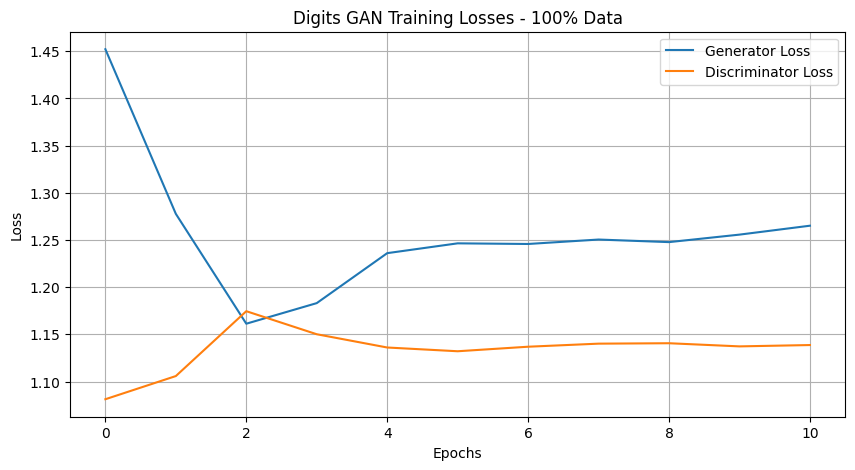

[Epoch 11/100] [Batch 0/468] [D loss: 1.0844] [G loss: 1.7079] [Time: 253.93s]
[Epoch 11/100] [Batch 100/468] [D loss: 1.0483] [G loss: 1.4266] [Time: 258.91s]
[Epoch 11/100] [Batch 200/468] [D loss: 1.0741] [G loss: 1.1562] [Time: 263.87s]
[Epoch 11/100] [Batch 300/468] [D loss: 1.2084] [G loss: 1.1324] [Time: 268.80s]
[Epoch 11/100] [Batch 400/468] [D loss: 1.1828] [G loss: 1.2559] [Time: 274.19s]
[Epoch 11/100] [Avg D loss: 1.1344] [Avg G loss: 1.2701]
[Epoch 12/100] [Batch 0/468] [D loss: 1.1801] [G loss: 1.4377] [Time: 277.79s]
[Epoch 12/100] [Batch 100/468] [D loss: 1.1594] [G loss: 1.2579] [Time: 282.77s]
[Epoch 12/100] [Batch 200/468] [D loss: 1.1340] [G loss: 1.2922] [Time: 287.72s]
[Epoch 12/100] [Batch 300/468] [D loss: 1.2347] [G loss: 1.3505] [Time: 292.71s]
[Epoch 12/100] [Batch 400/468] [D loss: 1.1578] [G loss: 1.3878] [Time: 297.71s]
[Epoch 12/100] [Avg D loss: 1.1286] [Avg G loss: 1.2772]
[Epoch 13/100] [Batch 0/468] [D loss: 1.0810] [G loss: 1.2265] [Time: 301.07s]
[

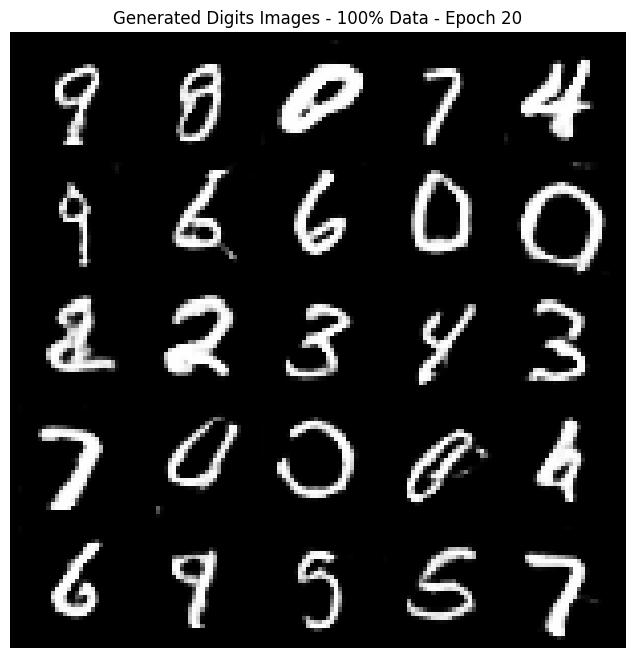

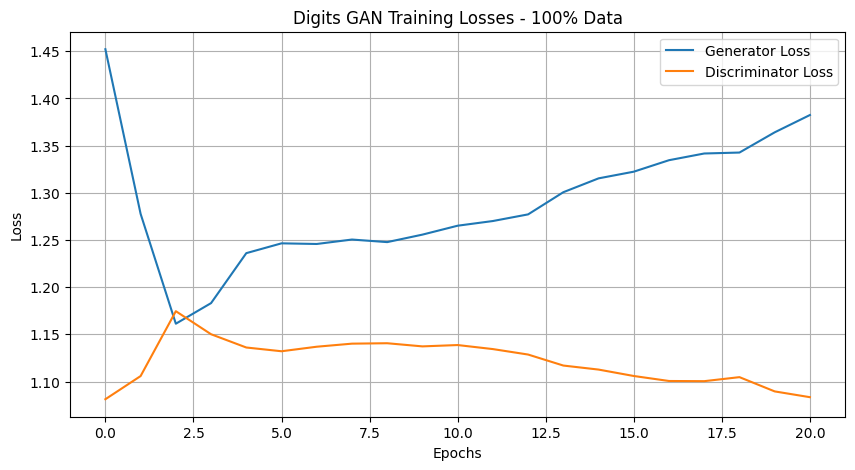

[Epoch 21/100] [Batch 0/468] [D loss: 1.1326] [G loss: 1.3006] [Time: 489.64s]
[Epoch 21/100] [Batch 100/468] [D loss: 1.0104] [G loss: 0.9183] [Time: 494.65s]
[Epoch 21/100] [Batch 200/468] [D loss: 0.9176] [G loss: 1.3935] [Time: 499.62s]
[Epoch 21/100] [Batch 300/468] [D loss: 1.0564] [G loss: 0.8780] [Time: 504.59s]
[Epoch 21/100] [Batch 400/468] [D loss: 0.9724] [G loss: 1.5466] [Time: 509.55s]
[Epoch 21/100] [Avg D loss: 1.0772] [Avg G loss: 1.3890]


KeyboardInterrupt: 

In [14]:
set_random_seed(42)
# set cuda seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(42)

# Parameters for the trainng run
dataset_type = 'digits'  # Change to 'fashion' for Fashion MNIST
subset_percentage = 100  # Percentage of the dataset to use (1-100)

# Train the GAN
g_losses, d_losses = train_gan(subset_percentage, dataset_type)

In [ ]:
set_random_seed(42)
# set cuda seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(42)
#clear cuda cache
torch.cuda.empty_cache()

# Initialize models
generator = Generator(latent_dim, hidden_dim, image_size).to(device)
discriminator = Discriminator(image_size, hidden_dim).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Parameters for the trainng run
dataset_type = 'digits'  # Change to 'fashion' for Fashion MNIST
subset_percentage = 10  # Percentage of the dataset to use (1-100)

# Train the GAN
g_losses, d_losses = train_gan(subset_percentage, dataset_type)

### Results Analysis

Let's examine our final loss plot and generate some images with the trained model.

In [ ]:
# Plot the losses
plot_losses(g_losses, d_losses, subset_percentage, dataset_type)

In [ ]:
# Generate random samples after training
generate_samples(dataset_type)

## 9. Next Steps for Thesis Research

1. **Data Subset Selection Strategies**:
   - Random sampling (as baseline)
   - Figure out a way to get informed subsest of the data
   - Compare subset selection effectiveness between Digits MNIST and Fashion MNIST

2. **Evaluation Metrics**:
   - Frechet Inception Distance (FID)
   - Inception Score (IS)
   - Precision and Recall metrics
   - Training stability measures

3. **Experiments to Run**:
   - Train with different subset sizes (10%, 20%, 30%, etc.)
   - Compare different subset selection methods
   - Analyze what makes certain samples more "informative" for GANs
   - Test if informative samples transfer across different GAN architectures
   - Compare the characteristics of informative samples between Digits MNIST and Fashion MNIST
   - Investigate whether informative samples from one dataset can generalize to another similar dataset

In [ ]:
import pandas as pd
from torchvision.utils import make_grid
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

import matplotlib.pyplot as plt

# Load the EL2N scores CSV
el2n_scores = pd.read_csv('el2n_scores_fashion.csv')

# Sort by EL2N scores in descending order and select the top 100
top_100 = el2n_scores.sort_values(by='el2n_score', ascending=False).head(225)

# Load the corresponding images from the dataset
# Assuming the dataset is MNIST and images are indexed by 'index' column in the CSV

transform = Compose([ToTensor(), Normalize([0.5], [0.5])])
mnist_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Extract the images corresponding to the top 100 indices
top_100_images = torch.stack([mnist_dataset[int(top_100.iloc[i]['index'])][0] for i in range(225)])

# Create a grid of images
grid = make_grid(top_100_images, nrow=15, normalize=True)

# Plot the grid
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title("Top 225 Digits with Highest EL2N Scores")
plt.show()

In [ ]:
# Sort by EL2N scores in ascending order and select the bottom 100
lowest_100 = el2n_scores.sort_values(by='el2n_score', ascending=True).head(225)

# Extract the images corresponding to the lowest 100 indices
lowest_100_images = torch.stack([mnist_dataset[int(lowest_100.iloc[i]['index'])][0] for i in range(225)])

# Create a grid of images
grid = make_grid(lowest_100_images, nrow=15, normalize=True)

# Plot the grid
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title("Bottom 225 Digits with Lowest EL2N Scores")
plt.show()

In [ ]:
# Plot the distribution of EL2N scores
plt.figure(figsize=(10, 6))
plt.hist(el2n_scores['el2n_score'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of EL2N Scores')
plt.xlabel('EL2N Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.xscale('linear')
plt.show()

In [ ]:
def count_high_el2n_scores(threshold):
    count = el2n_scores[el2n_scores['el2n_score'] > threshold].shape[0]
    print(f"Number of datapoints with EL2N score higher than {threshold}: {count}")

# Example usage
count_high_el2n_scores(0.5)

In [ ]:
# Calculate the 70th percentile of EL2N scores
percentile_70 = el2n_scores['el2n_score'].quantile(0.5)

# Define a range around the 70th percentile (e.g., ±5% of the score)
tolerance = 0.05 * percentile_70
lower_bound = percentile_70 - tolerance
upper_bound = percentile_70 + tolerance

# Filter the dataset for EL2N scores within this range
around_70_percentile = el2n_scores[
    (el2n_scores['el2n_score'] >= lower_bound) & 
    (el2n_scores['el2n_score'] <= upper_bound)
].head(225)

# Extract the images corresponding to the filtered indices
images_around_70 = torch.stack([mnist_dataset[int(around_70_percentile.iloc[i]['index'])][0] for i in range(len(around_70_percentile))])

# Create a grid of images
grid = make_grid(images_around_70, nrow=15, normalize=True)

# Plot the grid
plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title("225 Images with EL2N Scores Around the 70th Percentile")
plt.show()

In [ ]:
# Calculate the median of EL2N scores
median_score = el2n_scores['el2n_score'].median()

# Filter the lower 50% of EL2N scores
lower_50_percent = el2n_scores[el2n_scores['el2n_score'] <= median_score]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(lower_50_percent['el2n_score'], bins=200, color='green', alpha=0.7)
plt.title('Distribution of EL2N Scores (Lower 50%)')
plt.xlabel('EL2N Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()